In [26]:
import pandas as pd 
data = pd.read_csv('CE802_Ass_2019_Data.csv').sample(frac=1, random_state=42)
test_features = pd.read_csv('CE802_Ass_2019_Test.csv').drop("Class", axis=1)

In [27]:
cor_mat = data.corr()
cor_mat["Class"].sort_values(ascending=False);

In [28]:
split = int(len(data) * 0.13)
validation = data[0:split]
train = data[split:]

In [29]:
train_labels = train["Class"]
train_features = train.drop("Class", axis=1)
validation_labels = validation["Class"]
validation_features = validation.drop("Class", axis=1)

In [34]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score

def featureSelection(X, level='low'):
    if level == 'low':
        return X
    if level == 'mid':
        return X.drop(['F18', 'F8', 'F11', 'F17'], axis=1)
    if level == 'high':
        return X.drop(['F3', 'F5', 'F18', 'F8', 'F11', 'F17', 'F6', 'F2'], axis=1)

def imputeF20(X, method='none'):
    if method == 'none':
        return pd.DataFrame(X)
    if method == 'drop':
        X = X.drop("F20",axis=1).values
        return pd.DataFrame(X)
    if method == 'constant':
        imp = SimpleImputer(strategy='constant')
    if method == 'mean':
        imp = SimpleImputer(strategy='mean')
    if method == 'knn':
        imp = KNNImputer(n_neighbors=5)

    imp.fit(X)
    return pd.DataFrame(imp.transform(X))

def scale(X, method='none'):
    if method == 'none':
        return pd.DataFrame(X)
    if method == 'norm':
        scaler = MinMaxScaler()
    if method == 'std':
        scaler = StandardScaler()
    
    scaler.fit(X)
    return pd.DataFrame(scaler.transform(X))

def evaluateClassifier(clf):
    clf.fit(train_features_procesed, train_labels)
    results = clf.predict(validation_features_procesed)
    # print(results.shape)
    # print(validation_labels.shape)
    return f1_score(validation_labels, results)

In [35]:
selection_level = 'mid'
imputation_method = 'knn'
scaling_method = 'norm'

train_features_procesed = featureSelection(train_features, selection_level)
train_features_procesed = imputeF20(train_features_procesed, imputation_method)
train_features_procesed = scale(train_features_procesed, scaling_method )

validation_features_procesed = featureSelection(validation_features, selection_level)
validation_features_procesed = imputeF20(validation_features_procesed, imputation_method)
validation_features_procesed = scale(validation_features_procesed, scaling_method )

In [37]:
### Dumb model
from sklearn.dummy import DummyClassifier
clf_dummy = DummyClassifier(strategy="most_frequent")
dummy_f1 = evaluateClassifier(clf_dummy)
print(dummy_f1)

0.0


In [33]:
clf_d = DummyClassifier(strategy="most_frequent")
clf_d.fit(train_features_procesed , train_labels)
results = clf_d.predict(validation_features_procesed)
print(type(results))
print(results)
print(type(validation_labels.values))
print(validation_labels.values)
print(f1_score(validation_labels.values, results))

<class 'numpy.ndarray'>
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
<class 'numpy.ndarray'>
[ True  True  True  True False False False  True  True False  True  True
  True False False  True  True  True False False False False False  True
  True False False  True False False False False  True False False  True
  True False False  True  True  True  True False False False  True False
  True  True False False False False False  True  True False False False
 False  True False False False]
0.0


In [9]:
#### Prunned Decision tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [10]:
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(train_features_procesed, train_labels)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [11]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(train_features_procesed, train_labels)
    clfs.append(clf)

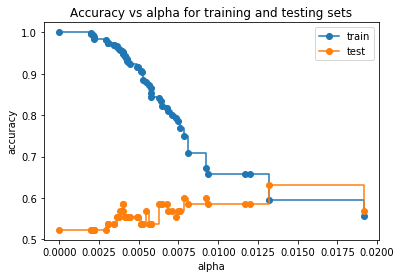

In [12]:
train_scores = [clf.score(train_features_procesed, train_labels) for clf in clfs]
test_scores = [clf.score(validation_features_procesed, validation_labels) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [13]:
from sklearn.metrics import f1_score

clf_decision_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=0.01)
decision_tree_f1 = evaluateClassifier(clf_decision_tree)
print(decision_tree_f1)

0.49056603773584906


In [14]:
### Logistic Regression
from sklearn.linear_model import LogisticRegression

clf_logistic_reg = LogisticRegression(random_state=42)
logistic_reg_f1 = evaluateClassifier(clf_logistic_reg)
print(logistic_reg_f1)

0.4727272727272727


In [15]:
### Support vector machines
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
params = [
    {'kernel':['linear', 'rbf', 'sigmoid']},
    {'kernel': ['rbf'], 'gamma':[0.001, 0.01, 0.1, 0.5, 1, 10, 100]}
]
clf = SVC()
grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
grid_search.fit(train_features_procesed, train_labels)
print(grid_search.best_estimator_)

clf_svc = SVC(kernel='rbf', gamma=1)
svm_f1 = evaluateClassifier(clf_svc)
print(svm_f1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
0.5185185185185186


In [16]:
### KNN
from sklearn.neighbors import KNeighborsClassifier
params = [
    {'n_neighbors':[3,4,5,7,9], 'weights': ['uniform', 'distance'], 'algorithm':['auto'], 'p':[1, 2]}
    ]
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
grid_search.fit(train_features_procesed, train_labels)
print(grid_search.best_estimator_)



clf_knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', n_neighbors=3, p=2, weights='uniform')
knn_f1 = evaluateClassifier(clf_knn)
print(knn_f1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
0.5161290322580646


In [17]:
### Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf_naive_bayes = GaussianNB()
naive_bayes_f1 = evaluateClassifier(clf_naive_bayes)
print(naive_bayes_f1)

0.49180327868852464


In [18]:
### Perceptron
from sklearn.linear_model import Perceptron

params = [
        {'penalty':[None,'l1', 'l2', 'elasticnet']}
    ]
clf = Perceptron()
grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
grid_search.fit(train_features_procesed, train_labels)
print(grid_search.best_estimator_)

clf_perceptron = Perceptron(penalty='l2')
perceptron_f1 = evaluateClassifier(clf_perceptron)
print(perceptron_f1)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty='l2', random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
0.5681818181818182


In [19]:
### MLP
from sklearn.neural_network import MLPClassifier

params = [{
            'hidden_layer_sizes':[(10, ),(30,),(50, ),(100, )],
            'activation':['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'adam'],
            'alpha':[0.0001, 0.001, 0.01],
            'learning_rate': ['constant','invscaling','adaptive'],
            'random_state': [0],
            'early_stopping': [True],
            'max_iter': [300]
        }]
# clf = MLPClassifier()
# grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
# grid_search.fit(train_features_procesed, train_labels);
# print(grid_search.best_estimator_)

clf_mlp = MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(30,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
mlp_f1 = evaluateClassifier(clf_mlp)
print(mlp_f1)

0.6666666666666665
/Users/edlgg/GoogleDrive/Essex/Machine Learning and Data Mining/Project/ML_and_DM_Social_Network/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [20]:
### Random Forest
from sklearn.ensemble import RandomForestClassifier
params = [{
    'n_estimators': [50,100,200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,5,7,9],
    'min_samples_split': [2,4,6,8],
    'min_samples_leaf': [1,2,3,4],
    'ccp_alpha': [0.001, 0.005, 0.01, 0.012]
}]
# clf = RandomForestClassifier()
# grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
# grid_search.fit(train_features_procesed, train_labels);
# print(grid_search.best_estimator_)

clf_random_forest = RandomForestClassifier(bootstrap=True, ccp_alpha=0.005, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
random_forest_f1 = evaluateClassifier(clf_random_forest)
print(random_forest_f1)

0.5714285714285714


In [21]:
from sklearn.ensemble import GradientBoostingClassifier

params = [{
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 125, 150],
    'min_samples_split': [2,3,5,6],
    'min_samples_leaf': [1, 2, 3, 4],
    'ccp_alpha': [0.001, 0.005, 0.01, 0.012]
}]

# clf = GradientBoostingClassifier()
# grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True, n_jobs=5)
# grid_search.fit(train_features_procesed, train_labels);
# print(grid_search.best_estimator_)

clf_gradient_boosting = GradientBoostingClassifier(ccp_alpha=0.001, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=125,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
gradient_boosting_f1 = evaluateClassifier(clf_gradient_boosting)
print(gradient_boosting_f1)

0.5762711864406779


In [22]:
from sklearn.ensemble import StackingClassifier
estimators = [
    ('clf_decision_tree', clf_decision_tree),
    ('clf_logistic_reg', clf_logistic_reg),
    ('clf_svc', clf_svc),
    ('clf_naive_bayes', clf_naive_bayes),
    ('clf_perceptron', clf_perceptron),
    ('clf_mlp', clf_mlp),
    ('clf_random_forest', clf_random_forest),
    ('clf_gradient_boosting', clf_gradient_boosting),
]
clf_stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_f1 = evaluateClassifier(clf_stacking)
print(stacking_f1)

/Users/edlgg/GoogleDrive/Essex/Machine Learning and Data Mining/Project/ML_and_DM_Social_Network/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/edlgg/GoogleDrive/Essex/Machine Learning and Data Mining/Project/ML_and_DM_Social_Network/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [23]:
from sklearn.ensemble import VotingClassifier
estimators = [
    ('clf_decision_tree', clf_decision_tree),
    # ('clf_logistic_reg', clf_logistic_reg),
    # ('clf_svc', clf_svc),
    # ('clf_naive_bayes', clf_naive_bayes),
    # ('clf_perceptron', clf_perceptron),
    # ('clf_mlp', clf_mlp),
    # ('clf_random_forest', clf_random_forest),
    # ('clf_gradient_boosting', clf_gradient_boosting),
]
clf_voting = VotingClassifier(estimators=estimators, voting='soft')
voting_f1 = evaluateClassifier(clf_voting)
print(voting_f1)

0.49056603773584906


In [24]:
# low: 0.57 0.60
# mid: 0.62 0.64
# high: 0.47 0.44

/Users/edlgg/GoogleDrive/Essex/Machine Learning and Data Mining/Project/ML_and_DM_Social_Network/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/edlgg/GoogleDrive/Essex/Machine Learning and Data Mining/Project/ML_and_DM_Social_Network/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/edlgg/GoogleDrive/Essex/Machine Learning and Data Mining/Project/ML_and_DM_Social_Network/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise a

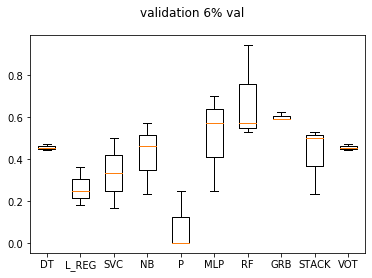

In [25]:
from sklearn import model_selection
models = [
    ('DT', clf_decision_tree),
    ('L_REG', clf_logistic_reg),
    ('SVC', clf_svc),
    ('NB', clf_naive_bayes),
    ('P', clf_perceptron),
    ('MLP', clf_mlp),
    ('RF', clf_random_forest),
    ('GRB', clf_gradient_boosting),
    ('STACK', clf_stacking),
    ('VOT', clf_voting),
]

results = []
names = []
scoring = 'f1'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=42)
	cv_results = model_selection.cross_val_score(model, validation_features_procesed, validation_labels, cv=3, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('validation 6% val')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()